In [1]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots, DifferentialEquations, NeuralVerification
const NNA = NeuralNetworkAnalysis
const RA = ReachabilityAnalysis
const NV = NeuralVerification

┌ Info: Precompiling NeuralNetworkAnalysis [73c0b437-a350-4e9b-97ac-9adb151c271b]
└ @ Base loading.jl:1278


NeuralVerification

In [2]:
controller = NNA.read_nnet_mat("/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/Sherlock-Benchmark-9-TORA/controllerTora.mat", act_key="act_fcns");

In [150]:
@taylorize function benchmark9!(dx, x, p, t)
    x₁, x₂, x₃, x₄, u = x

    aux = 0.1 * sin(x₃)
    dx[1] = x₂
    dx[2] = -x₁ + aux
    dx[3] = x₄
    dx[4] = u
    dx[5] = zero(u)
end

In [151]:
X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6])

U₀ = Universe(1)
prob = @ivp(x' = benchmark9!(x), dim: 5, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>[5]);
using NeuralNetworkAnalysis: UniformAdditiveNormalization
UAN = UniformAdditiveNormalization(-10.0)
plant = ControlledPlant(prob, controller, vars_idx, 1.0, UAN);

safe_states = BallInf(zeros(2), 2.0);

# Simulation

In [152]:
sim = simulate(plant, T=20.0);

In [156]:
fig = plot(xlab="x₁", ylab="x₂")
#plot!(fig, safe_states, color=:white, linecolor=:black, lw=5.0)
xl = xlims()
yl = ylims()
for simulation in trajectories(sim)
    for piece in simulation
        plot!(fig, piece, vars=(0, 3), lab="")
    end
end
#plot!(fig, project(X₀, 1:2), lab="X₀", size=(600,600))
xlims!(0, 4)
ylims!(-3, 3)

# Reachability Analysis

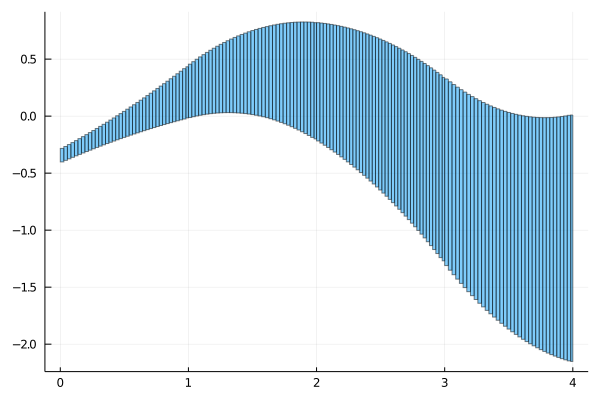

In [138]:
plot(sol, vars=(0, 3), lab="")

In [145]:
sol = NNA.solve(plant, T=4.0, alg_nn=Ai2(), alg=TMJets(orderT=6));

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0.208653, 0.265748])
Interval{Float64,IntervalArithmetic.Interval{Float64}}([-2.09168, 0.145613])
Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.78683, 0.235918])
Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.0565256, 2.24307])


In [144]:
fig2 = deepcopy(fig)
plot(fig2)
plot!(sol, vars=(1, 2), lab="")

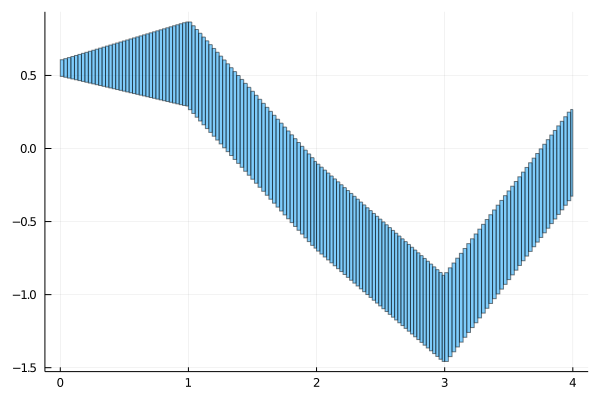

In [139]:
plot(sol, vars=(0, 4), lab="")

## Ai2 on T=1

In [118]:
u = overapproximate(forward_network(Ai2(), controller, sol), Interval) + Interval(-10., -10.) |> concretize

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-2.09168, 0.145613])

In [126]:
samples = sample(sol, 100000)
outputs = Vector()
for i in samples
    push!(outputs, NV.compute_output(controller, i) - [10.0])
end

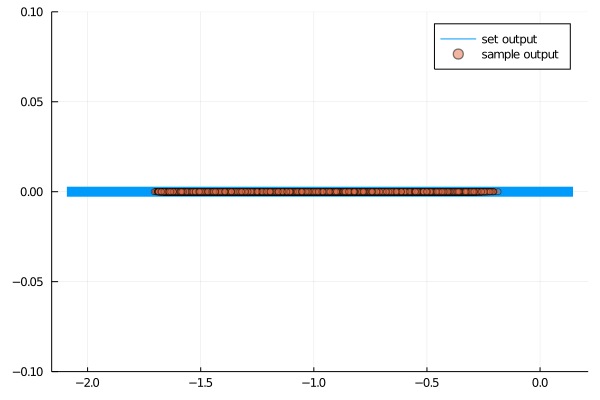

In [129]:
plot(u, lw=10, label="set output")
plot!(Singleton.(outputs), label="sample output", fmt=:png)
ylims!((-0.1, 0.1))